In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from matplotlib import pyplot as plt
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler
from sklearn import metrics
from collections import Counter
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix



In [2]:
# loading the dataset

# from google.colab import drive
# drive.mount('/content/gdrive')
# df=pd.read_csv('gdrive/My Drive/Colab Notebooks/BT4012 Project/ccFraud.csv')
df=pd.read_csv('ccFraud.csv')


In [ ]:
numerical_variables = ["balance","numTrans","numIntlTrans","creditLine"]
cat_variables = ["gender", "state" , "cardholder"]

df

,custID,gender,state,cardholder,balance,numTrans,numIntlTrans,creditLine,fraudRisk
0,1,1,35,1,3000,4,14,2,0
1,2,2,2,1,0,9,0,18,0
2,3,2,2,1,0,27,9,16,0
3,4,1,15,1,0,12,0,5,0
4,5,1,46,1,0,11,16,7,0
...,...,...,...,...,...,...,...,...,...
9999995,9999996,1,37,1,0,10,0,9,0
9999996,9999997,1,16,1,0,33,2,4,0
9999997,9999998,1,24,1,9000,38,0,8,0
9999998,9999999,1,28,1,7000,20,19,6,0


#  Cardinality and unique count (for categorical descriptive analysis)

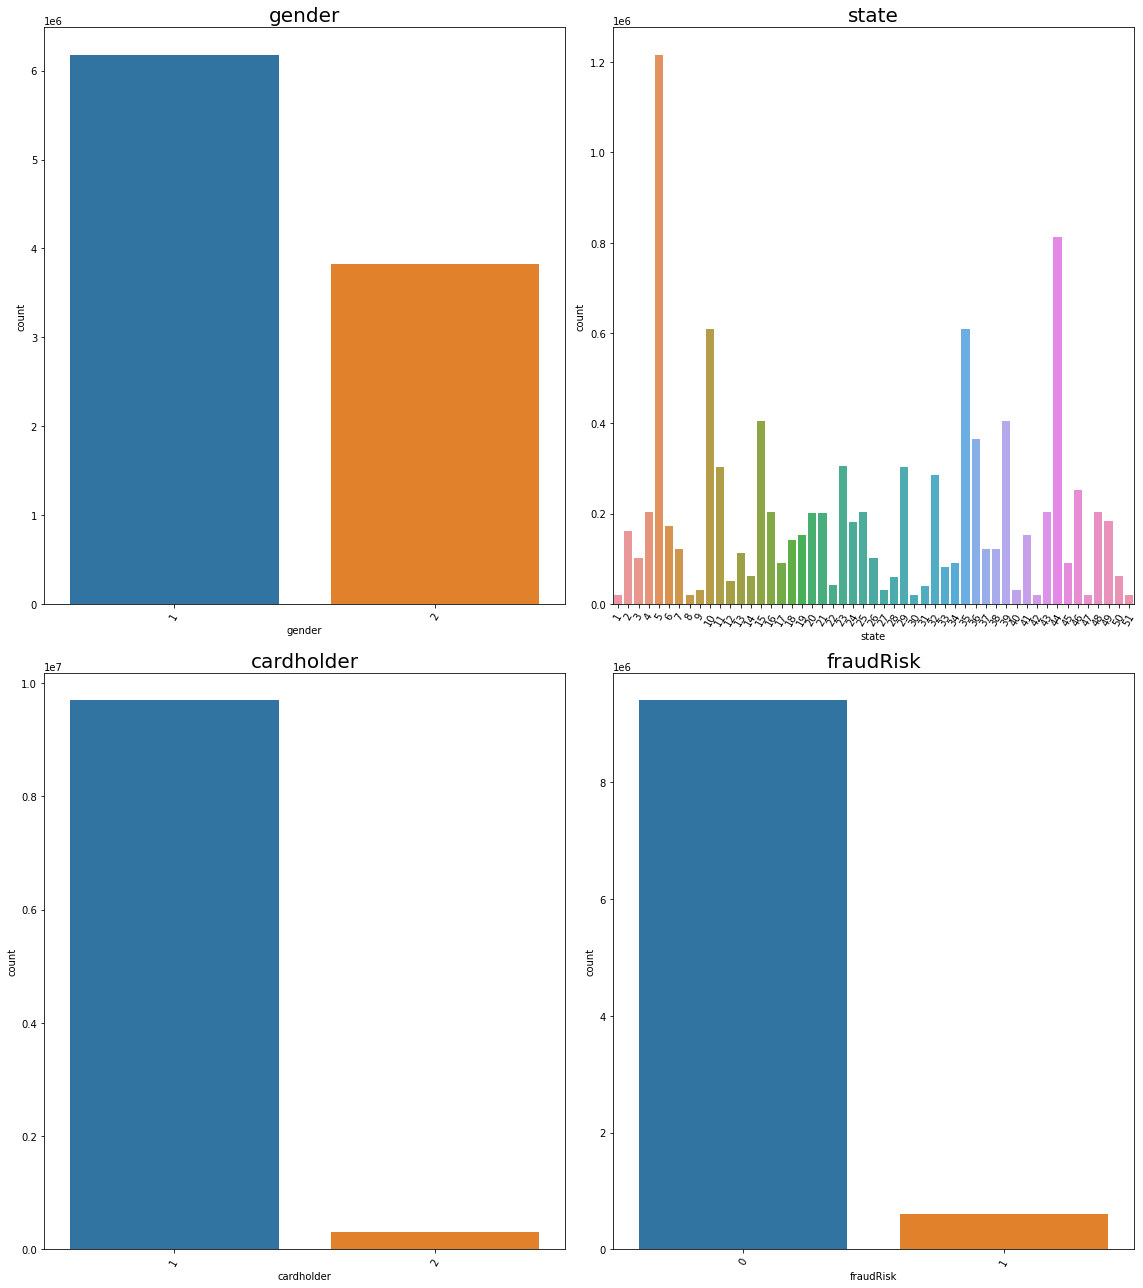

In [ ]:
# Set up the matplotlib figure
f, axes = plt.subplots(2, 2, figsize=(16,18), sharex=False)
# sns.despine(left=True)
var=["gender", "state" , "cardholder","fraudRisk"]
for index, name in enumerate(var):
    sns.countplot(x=name, data=df, ax=axes[index//2,index%2])
    axes[index//2,index%2].set_title(name, fontsize=20)
    axes[index//2,index%2].set_xticklabels(axes[index//2,index%2].get_xticklabels(), rotation=60)
plt.tight_layout()

In [ ]:
quantile = df[numerical_variables].describe().loc[['min', '25%', '50%', '75%', 'max']].transpose()
quantile.columns = ['min', 'Q1', 'Q2', 'Q3', 'max']
quantile['range'] = quantile['max'] - quantile['min']
quantile['IQR'] = quantile['Q3'] - quantile['Q1']
quantile

,min,Q1,Q2,Q3,max,range,IQR
balance,0.0,0.0,3706.0,6000.0,41485.0,41485.0,6000.0
numTrans,0.0,10.0,19.0,39.0,100.0,100.0,29.0
numIntlTrans,0.0,0.0,0.0,4.0,60.0,60.0,4.0
creditLine,1.0,4.0,6.0,11.0,75.0,74.0,7.0


# The paper have sampled 2% of the data with the same imbalance ratio for the experiment

In [ ]:
df.fraudRisk.value_counts()[0]/(df.fraudRisk.value_counts()[1]*15)

1.0518752915199978

In [ ]:
#IMBALANCE RATIO
ratio=df.fraudRisk.value_counts()[0]/df.fraudRisk.value_counts()[1]

#15.778:1
not_fraud_size=0.02*df.fraudRisk.value_counts()[0]
fraud_size=(0.02*df.fraudRisk.value_counts()[1])

not_fraud=df[df.fraudRisk==0].sample(frac=0.02)
fraud=df[df.fraudRisk==1].sample(frac=0.02)

In [ ]:
df_sample=pd.concat([fraud,not_fraud])
np.random.shuffle(df_sample.values)
df_sample.head(50)

,custID,gender,state,cardholder,balance,numTrans,numIntlTrans,creditLine,fraudRisk
5341708,8946443,2,41,1,3186,34,2,8,0
7214692,9231015,2,28,1,3000,16,0,2,0
6409449,772280,2,46,1,6000,36,2,5,0
5249316,4510513,1,4,1,6000,5,3,5,0
9724281,6407367,1,48,1,5000,29,1,4,0
2443753,8984923,1,49,1,2000,27,6,1,0
750128,9339261,1,46,2,4000,54,2,3,0
4518410,2785124,1,45,1,11000,10,0,10,0
5600738,8038238,2,15,1,3000,4,0,2,0
5770247,1584138,2,35,1,0,20,0,3,0


In [ ]:
df_sample=df_sample.reset_index()
df_sample

,index,custID,gender,state,cardholder,balance,numTrans,numIntlTrans,creditLine,fraudRisk
0,5341708,8946443,2,41,1,3186,34,2,8,0
1,7214692,9231015,2,28,1,3000,16,0,2,0
2,6409449,772280,2,46,1,6000,36,2,5,0
3,5249316,4510513,1,4,1,6000,5,3,5,0
4,9724281,6407367,1,48,1,5000,29,1,4,0
...,...,...,...,...,...,...,...,...,...,...
199995,7249582,7966749,1,44,1,0,13,0,2,0
199996,617135,4123504,2,5,1,8907,66,0,22,1
199997,9342156,1164599,2,14,1,0,21,0,4,0
199998,1278728,6165123,1,29,1,0,8,0,10,0


In [ ]:

X=df_sample[["balance","numTrans","numIntlTrans","creditLine","gender", "state" , "cardholder"]]
y=df_sample.fraudRisk 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

##Multicollinearity Test

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
X = df_sample.iloc[:,2:-1]
calc_vif(X)


,variables,VIF
0,gender,7.643228
1,state,3.519527
2,cardholder,10.759277
3,balance,2.182226
4,numTrans,2.130942
5,numIntlTrans,1.218857
6,creditLine,2.026278


# SVM

In [ ]:

param = {'C': [0.1, 1, 10],
              'kernel': ['rbf']}

metric = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'accuracy_score': make_scorer(accuracy_score)
}
 

SVM = SVC()

In [ ]:
def grid_search(eval_score):
    """
    fits a GridSearchCV classifier using refit_score for optimization
    prints classifier performance metrics
    """
    skf = StratifiedKFold(n_splits=5)
    grid_search = GridSearchCV(SVM, param, scoring=metric, refit=eval_score,
                           cv=skf,return_train_score=True)
    grid_search.fit(X_train, y_train)

    # make the predictions
    y_pred = grid_search.predict(X_test)

    print('Best params for {}'.format(eval_score))
    print(grid_search.best_params_)

    # confusion matrix on the test data.
    print('\nConfusion matrix of Random Forest optimized for {} on the test data:'.format(eval_score))
    print(pd.DataFrame(confusion_matrix(y_test, y_pred),
                 columns=['pred_neg', 'pred_pos'], index=['neg', 'pos']))
    
    return grid_search

In [ ]:
grid_search_clf = grid_search('recall_score')
results = pd.DataFrame(grid_search_clf.cv_results_)
results = results.sort_values(by='mean_test_recall_score', ascending=False)


Best params for recall_score
{'C': 10, 'kernel': 'rbf'}

Confusion matrix of Random Forest optimized for recall_score on the test data:
     pred_neg  pred_pos
neg     56151       283
pos      2694       872


In [ ]:
results[['mean_test_precision_score', 'mean_test_recall_score', 'mean_test_accuracy_score', 'param_C','param_kernel']].round(3).head(6)


,mean_test_precision_score,mean_test_recall_score,mean_test_accuracy_score,param_C,param_kernel
2,0.761,0.253,0.951,10,rbf
1,0.743,0.210,0.949,1,rbf
0,0.741,0.200,0.948,0.1,rbf


In [ ]:
from sklearn.svm import SVC
svclassifier = SVC(C=10,probability=True)
svclassifier.fit(X_train, y_train)



SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [ ]:

y_pred = svclassifier.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9503833333333334


In [ ]:

print(confusion_matrix(y_test, y_pred))
# print(classification_report(y_test, y_pred_sig))
con=confusion_matrix(y_test, y_pred)
sensitivity=con[1][1]/(con[1][1]+con[1][0])
sensitivity

[[56151   283]
 [ 2694   872]]


0.24453168816601234

In [ ]:
y_prob=svclassifier.predict_proba(X_test)



In [ ]:
auprc = metrics.average_precision_score(y_test,y_prob[:,1])
auprc


0.5478229982649002

## Cost Sensitive SVM

In [4]:

def Cost_sensitive_SVM(weights,X,y):

    accuracy=[]
    sensitivity=[]
    auprc=[]
    for i in weights:
        svclassifier = SVC(C=10,probability=True,class_weight=i)
        svclassifier.fit(X_train, y_train)
        y_pred = svclassifier.predict(X_test)
        accuracy.append(metrics.accuracy_score(y_test, y_pred))
        con=confusion_matrix(y_test, y_pred)
        sensitivity.append(con[1][1]/(con[1][1]+con[1][0]))
        y_prob=svclassifier.predict_proba(X_test)
        auprc.append(metrics.average_precision_score(y_test,y_prob[:,1]))

    result=pd.DataFrame({"weights":weights,"accuracy":accuracy,"sensitivity":sensitivity,"auprc":auprc})

    return result


In [ ]:
weights =[{0:1, 1:3},{0:1, 1:5}, {0:1, 1:10}]
result=Cost_sensitive_SVM(weights,X_train,y_train)
result

,weights,accuracy,sensitivity,auprc
0,"{0: 1, 1: 3}",0.950033,0.597087,0.622657
1,"{0: 1, 1: 5}",0.933800,0.721017,0.605109
2,"{0: 1, 1: 10}",0.894183,0.855511,0.552845


### Weigth chosen  {0: 1, 1: 3}

# DecisionTree (C5.0)

In [ ]:
clf = DecisionTreeClassifier()

param = {
    'criterion':["gini","entropy"],
    'max_depth': np.arange(2,18,2)
    
}

metric = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'accuracy_score': make_scorer(accuracy_score)
}

In [ ]:
def grid_search(eval_score):
    """
    fits a GridSearchCV classifier using refit_score for optimization
    prints classifier performance metrics
    """
    skf = StratifiedKFold(n_splits=10)
    grid_search = GridSearchCV(clf, param, scoring=metric, refit=eval_score,
                           cv=skf,return_train_score=True)
    grid_search.fit(X_train, y_train)

    # make the predictions
    y_pred = grid_search.predict(X_test)

    print('Best params for {}'.format(eval_score))
    print(grid_search.best_params_)

    # confusion matrix on the test data.
    print('\nConfusion matrix of Random Forest optimized for {} on the test data:'.format(eval_score))
    print(pd.DataFrame(confusion_matrix(y_test, y_pred),
                 columns=['pred_neg', 'pred_pos'], index=['neg', 'pos']))
    
    return grid_search

In [ ]:
grid_search_clf = grid_search('recall_score')

Best params for recall_score
{'criterion': 'gini', 'max_depth': 16}

Confusion matrix of Random Forest optimized for recall_score on the test data:
     pred_neg  pred_pos
neg     55116      1281
pos      1965      1638


###Eventhough best param is {'criterion': 'gini', 'max_depth': 16}, I will still use max-depth 8  as the overall performance for both precision and the recall is the higest. Inaddition, there is only a small difference in accuracy 


In [ ]:
results = pd.DataFrame(grid_search_clf.cv_results_)
results = results.sort_values(by='mean_test_recall_score', ascending=False)
results[['mean_test_precision_score', 'mean_test_recall_score', 'mean_test_accuracy_score', 'param_max_depth']].round(3).head(6)

,mean_test_precision_score,mean_test_recall_score,mean_test_accuracy_score,param_max_depth
7,0.553,0.445,0.946,16
15,0.547,0.441,0.945,16
6,0.597,0.432,0.949,14
14,0.598,0.431,0.949,14
5,0.648,0.428,0.952,12
3,0.725,0.420,0.956,8


In [ ]:


#selected param: max-depth=8

In [ ]:
decision_tree = DecisionTreeClassifier(random_state=0,max_depth=8)
decision_tree = decision_tree.fit(X_train, y_train)

y_pred = decision_tree.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9561333333333333


In [ ]:

print(confusion_matrix(y_test, y_pred))
con=confusion_matrix(y_test, y_pred)
sensitivity=con[1][1]/(con[1][1]+con[1][0])
sensitivity

[[55812   585]
 [ 2047  1556]]


0.43186233694143766

In [ ]:

y_pob=decision_tree.predict_proba(X_test)
auprc = metrics.average_precision_score(y_test,y_pob[:,1])
auprc

0.6237588064383528

# Over-sampling Decision Tree (C5.0)
The sampling strategy serve as a proportion of minority we want after over sampling the minority data . Strategy equals to 0.5 means that if the majority class had 1,000 examples and the minority class had 100, the transformed dataset would have 500 examples of the minority class.

In [ ]:
df_sample.fraudRisk.value_counts()

0    188080
1     11920
Name: fraudRisk, dtype: int64

In [5]:


def DecisionTree_Over_sampling(strategy,X,y):

    accuracy=[]
    sensitivity=[]
    auprc=[]
    for i in strategy:
        
        oversample = RandomOverSampler(sampling_strategy=i)
        # fit and apply the transform
        X_train_over, y_train_over = oversample.fit_resample(X, y)


        decision_tree = DecisionTreeClassifier(random_state=0, max_depth=8)

        decision_tree = decision_tree.fit(X_train_over, y_train_over)
        y_pred = decision_tree.predict(X_test)
        accuracy.append(metrics.accuracy_score(y_test, y_pred))
        con=confusion_matrix(y_test, y_pred)
        sensitivity.append(con[1][1]/(con[1][1]+con[1][0]))

        y_prob=decision_tree.predict_proba(X_test)

        auprc.append(metrics.average_precision_score(y_test,y_prob[:,1]))

    result=pd.DataFrame({"strategy":strategy,"accuracy":accuracy,"sensitivity":sensitivity,"auprc":auprc})

    return result

  








In [ ]:
strategy=[0.1,0.18,0.2,0.35,0.5,1]
result=DecisionTree_Over_sampling(strategy,X_train,y_train)
result

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

,strategy,accuracy,sensitivity,auprc
0,0.10,0.953733,0.516057,0.621408
1,0.18,0.946767,0.620776,0.603744
2,0.20,0.944000,0.653170,0.613083
3,0.35,0.928000,0.744206,0.614591
4,0.50,0.911433,0.805641,0.615137
5,1.00,0.867150,0.881318,0.615005


Sampling atrategy of 0.1 is chosen as the auprc increased the most and the increase in sensitivity did not compromise the precision value as the similar auprc value and high sensitivity in other strategies indicates that the precision has decrease by alot.

In [ ]:
oversample = RandomOverSampler(sampling_strategy=0.45)
# fit and apply the transform
X_over, y_over = oversample.fit_resample(X_train, y_train)
# summarize class distributi
Counter(y_over)[1]

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


59247

In [ ]:

X_train_over, X_test_over, y_train_over, y_test_over = train_test_split(X_over, y_over, test_size=0.3, random_state=1)

In [ ]:

decision_tree = DecisionTreeClassifier(random_state=0, max_depth=8)
decision_tree = decision_tree.fit(X_train_over, y_train_over)

y_pred = decision_tree.predict(X_test_over)
print("Accuracy:",metrics.accuracy_score(y_test_over, y_pred))

Accuracy: 0.8916335635274705


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test_over, y_pred))
con=confusion_matrix(y_test_over, y_pred)
sensitivity=con[1][1]/(con[1][1]+con[1][0])
sensitivity

[[52287  4231]
 [ 4635 20662]]


0.8167766928884848

In [ ]:
y_prob=decision_tree.predict_proba(X_test_over)
y_prob

array([[0.93022217, 0.06977783],
       [0.20694259, 0.79305741],
       [0.99808493, 0.00191507],
       ...,
       [0.99808493, 0.00191507],
       [0.98241436, 0.01758564],
       [0.63636364, 0.36363636]])

In [ ]:
auprc = metrics.average_precision_score(y_test_over,y_prob[:,1])
auprc

0.8996188973853909

# Cost-Sensitive Decision Tree (C5.0)

In [6]:
def Cost_sensitive_Decision_Tree(weights,X,y):

    accuracy=[]
    sensitivity=[]
    auprc=[]
    for i in weights:
        
        decision_tree = DecisionTreeClassifier(random_state=0,class_weight=i, max_depth=8)
        decision_tree = decision_tree.fit(X_train, y_train)
        y_pred = decision_tree.predict(X_test)
        accuracy.append(metrics.accuracy_score(y_test, y_pred))
        con=confusion_matrix(y_test, y_pred)
        sensitivity.append(con[1][1]/(con[1][1]+con[1][0]))
        y_prob=decision_tree.predict_proba(X_test)
        auprc.append(metrics.average_precision_score(y_test,y_prob[:,1]))

    result=pd.DataFrame({"weights":weights,"accuracy":accuracy,"sensitivity":sensitivity,"auprc":auprc})

    return result



  


In [ ]:
weights =[{0:1, 1:2},{0:1, 1:3},{0:1, 1:5}, {0:1, 1:10},{0:1, 1:15},{0:1, 1:30}]
result=Cost_sensitive_Decision_Tree(weights,X_train,y_train)
result

,weights,accuracy,sensitivity,auprc
0,"{0: 1, 1: 2}",0.951483,0.582293,0.621497
1,"{0: 1, 1: 3}",0.947017,0.650847,0.633354
2,"{0: 1, 1: 5}",0.929183,0.746045,0.626476
3,"{0: 1, 1: 10}",0.899883,0.833472,0.624639
4,"{0: 1, 1: 15}",0.862250,0.890647,0.611111
5,"{0: 1, 1: 30}",0.831217,0.925340,0.610760


### Weight chosen: {0: 1, 1: 3}
### AUPRC is the highest

In [ ]:
weights = {0:1, 1:3}
decision_tree = DecisionTreeClassifier(random_state=0,class_weight=weights, max_depth=8)
decision_tree = decision_tree.fit(X_train, y_train)

y_pred = decision_tree.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9470166666666666


In [ ]:

print(confusion_matrix(y_test, y_pred))
con=confusion_matrix(y_test, y_pred)
sensitivity=con[1][1]/(con[1][1]+con[1][0])
sensitivity

[[54476  1921]
 [ 1258  2345]]


0.6508465167915626

In [ ]:
y_prob=decision_tree.predict_proba(X_test)
auprc = metrics.average_precision_score(y_test,y_prob[:,1])
auprc

0.6333544755739018

## Changing the imbalance ratio to 10:1 while maintaining same data size of 200,000

In [ ]:


not_fraud=df[df.fraudRisk==0].sample(n=181819)
fraud=df[df.fraudRisk==1].sample(n=18181)

df_sample_new=pd.concat([fraud,not_fraud])
np.random.shuffle(df_sample.values)
print("Ratio:")
print(df_sample_new.fraudRisk.value_counts()[0]/df_sample_new.fraudRisk.value_counts()[1])
df_sample_new.head()

Ratio:
10.000495022276002


,custID,gender,state,cardholder,balance,numTrans,numIntlTrans,creditLine,fraudRisk
8854333,8854334,2,5,1,13802,6,0,45,1
740948,740949,1,15,1,13668,100,0,14,1
1219975,1219976,1,34,1,8602,14,2,28,1
2481255,2481256,1,19,1,21000,30,0,20,1
4100041,4100042,2,5,1,7000,100,9,6,1


In [ ]:
df_sample_new=df_sample_new.reset_index()
df_sample_new


,index,custID,gender,state,cardholder,balance,numTrans,numIntlTrans,creditLine,fraudRisk
0,8854333,8854334,2,5,1,13802,6,0,45,1
1,740948,740949,1,15,1,13668,100,0,14,1
2,1219975,1219976,1,34,1,8602,14,2,28,1
3,2481255,2481256,1,19,1,21000,30,0,20,1
4,4100041,4100042,2,5,1,7000,100,9,6,1
...,...,...,...,...,...,...,...,...,...,...
199995,9779317,9779318,2,45,1,0,37,6,4,0
199996,4493582,4493583,1,44,1,0,17,0,3,0
199997,6166858,6166859,2,51,1,2848,34,0,3,0
199998,3366598,3366599,1,2,1,2504,13,2,3,0


In [ ]:
X_new=df_sample[["balance","numTrans","numIntlTrans","creditLine","gender", "state" , "cardholder"]]
y_new=df_sample.fraudRisk 
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X_new, y_new, test_size=0.3, random_state=1)

## Normal decision Tree

In [ ]:
decision_tree = DecisionTreeClassifier(random_state=0,max_depth=8,criterion='entropy')
decision_tree = decision_tree.fit(X_train_new, y_train_new)

y_pred = decision_tree.predict(X_test_new)

con=confusion_matrix(y_test_new, y_pred)
sensitivity=con[1][1]/(con[1][1]+con[1][0])
y_prob=decision_tree.predict_proba(X_test_new)
auprc = metrics.average_precision_score(y_test_new,y_prob[:,1])

print("Accuracy:",metrics.accuracy_score(y_test_new, y_pred))
print(confusion_matrix(y_test_new, y_pred))
print("auprc:",auprc)
print("sensitivity:",sensitivity)


Accuracy: 0.9566166666666667
[[55805   615]
 [ 1988  1592]]
auprc: 0.6248621560995613
sensitivity: 0.4446927374301676


## Decision Tree with Over-sampling of strategy=0.1

In [ ]:
oversample = RandomOverSampler(sampling_strategy=0.1)
# fit and apply the transform
X_train_over, y_train_over = oversample.fit_resample(X_train_new, y_train_new)

decision_tree = DecisionTreeClassifier(random_state=0, max_depth=8,criterion='entropy')

decision_tree = decision_tree.fit(X_train_over, y_train_over)
y_pred = decision_tree.predict(X_test)
accuracy=metrics.accuracy_score(y_test, y_pred)

# print(confusion_matrix(y_test_over, y_pred))
con=confusion_matrix(y_test, y_pred)
sensitivity=con[1][1]/(con[1][1]+con[1][0])

y_prob=decision_tree.predict_proba(X_test)

auprc=metrics.average_precision_score(y_test,y_prob[:,1])

print("Accuracy:",accuracy)

print("auprc:",auprc)
print("sensitivity:",sensitivity)
print(con)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Accuracy: 0.95675
auprc: 0.6598890800039856
sensitivity: 0.5241552638927673
[[55528   891]
 [ 1704  1877]]


## Cost Sensitive Decision Tree with weights (1:3)

In [ ]:
weights = {0:1, 1:3}
decision_tree = DecisionTreeClassifier(random_state=0,class_weight=weights, max_depth=8)
decision_tree = decision_tree.fit(X_train_new, y_train_new)

y_pred = decision_tree.predict(X_test_new)

con=confusion_matrix(y_test_new, y_pred)
sensitivity=con[1][1]/(con[1][1]+con[1][0])
y_prob=decision_tree.predict_proba(X_test_new)
auprc = metrics.average_precision_score(y_test_new,y_prob[:,1])

print("Accuracy:",metrics.accuracy_score(y_test_new, y_pred))
print(confusion_matrix(y_test_new, y_pred))
print("auprc:",auprc)
print("sensitivity:",sensitivity)


Accuracy: 0.9486833333333333
[[54619  1801]
 [ 1278  2302]]
auprc: 0.6243795618235152
sensitivity: 0.6430167597765363


## Noraml SVM

In [ ]:

svclassifier = SVC(C=10,probability=True)
svclassifier.fit(X_train_new, y_train_new)
y_pred = svclassifier.predict(X_test_new)
accuracy=metrics.accuracy_score(y_test_new, y_pred)

# print(confusion_matrix(y_test_over, y_pred))
con=confusion_matrix(y_test_new, y_pred)
sensitivity=con[1][1]/(con[1][1]+con[1][0])

y_prob=decision_tree.predict_proba(X_test_new)

auprc=metrics.average_precision_score(y_test_new,y_prob[:,1])

print("Accuracy:",accuracy)

print("auprc:",auprc)
print("sensitivity:",sensitivity)
print(con)

Accuracy: 0.9514666666666667
auprc: 0.6248621560995613
sensitivity: 0.27150837988826815
[[56116   304]
 [ 2608   972]]


## Cost sensitive SVM with weight {1:3} 

In [ ]:
weights = {0:1, 1:3}
svclassifier = SVC(C=10,probability=True,class_weight=weights)
svclassifier.fit(X_train_new, y_train_new)
y_pred = decision_tree.predict(X_test_new)

con=confusion_matrix(y_test_new, y_pred)
sensitivity=con[1][1]/(con[1][1]+con[1][0])
y_prob=decision_tree.predict_proba(X_test_new)
auprc = metrics.average_precision_score(y_test_new,y_prob[:,1])

print("Accuracy:",metrics.accuracy_score(y_test_new, y_pred))
print(confusion_matrix(y_test_new, y_pred))
print("auprc:",auprc)
print("sensitivity:",sensitivity)

Accuracy: 0.9566166666666667
[[55805   615]
 [ 1988  1592]]
auprc: 0.6248621560995613
sensitivity: 0.4446927374301676
